## Gradient Tree Boosting Classifier

This file uses gradient tree boosting to classify villages in Bihar, India into 2 groups:
1. unelectrified (<10% households are electrified)
2. electrified (>= 10% households are electrified)  

In addition, scholars in literature review have suggested that small villages emit such weak lights-at-night that satellites may have difficulty accurately picking it up. Thus we filter out too-small villages.  
Here our inputs are 3 dataframes of villages:  
1. all villages in dataset
2. villages with at least 100 households
3. villages with at least 400 households

Each dataframe contains:  
1. village identifiers, such as name and ID
2. features extracted from lights at night image (different code file!)
 
In this code, we run gradient tree boosting on all three dataframes, and evaluate classification results on ROC curves.  
Thanks for reading!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, os, gc
from pandas.plotting import scatter_matrix
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
from seaborn import heatmap, distplot
#from xgboost import XGBClassifier
#import xgboost as xgb

In [2]:
'''
Load data from .csv file  
dfall = all households included
df100 = threshold: 100 households (subset of dfall)
df400 = threshold: 400 households (subset of dfall)
'''
def read_csv_file(file_path):
     return pd.read_csv('interpolated_full.csv')


In [3]:
'''
Filter villages by number of households into 3 dataframes
'''
def get_filtered_thresholds(dfall):
    dfall = dfall.rename(columns={'Number of Households': 'Number_of_Households'})
    df100 = dfall.query('Number_of_Households > 100')
    df400 = dfall.query('Number_of_Households > 400')
    return dfall, df100, df400

In [4]:
'''
Assigns an electrification category to each village based on its percentage
Keeping this binary and with threshold 10% for now. 
'''
def get_labels(dfall, df100, df400):
    labels_all = (dfall['Percentage Electrified'] >= 10).tolist()
    labels_100 = (df100['Percentage Electrified'] >= 10).tolist()
    labels_400 = (df400['Percentage Electrified'] >= 10).tolist()
    return labels_all, labels_100, labels_400

In [5]:
'''
Delete non-predictive columns
'''
info_columns = ['Percentage Electrified', 'Number of Electrified Households', 'Unnamed: 0', 'Census 2011 ID', 'Number_of_Households']
def delete_info(df):
    for col_name in info_columns:
        del df[col_name]
def delete_objects(df):
    for i in df.columns:
            if df[i].dtype == "object":
                del df[i]
def remove_info_cols(df_bank):
    for df in df_bank:
        delete_info(df)
        delete_objects(df)


In [6]:
'''
PCA transformation with 104 components
'''
def pca_transform(data, labels):
    n_components = 104
    pca = PCA(n_components=n_components)
    return pd.DataFrame(pca.fit_transform(data, labels))


In [7]:
'''
Separate all 3 dataframes into training and testing
NOTE: dataframes are randomly sampled for simplicity, so there exists
    overlap between training and testing datasets
'''
# def separate_train_test_data(data, split):
#     RANDOM_SEED = 111
#     training = data.sample(frac=split, replace=False, random_state=RANDOM_SEED)
#     testing = data.sample(frac=1.0-split, replace=False, random_state=RANDOM_SEED)
#     return training, testing

# training_all, testing_all = separate_train_test_data(pca_dfall, 0.2)
# training_100, testing_100 = separate_train_test_data(pca_df100, 0.2)
# training_400, testing_400 = separate_train_test_data(pca_df400, 0.2)

'\nSeparate all 3 dataframes into training and testing\nNOTE: dataframes are randomly sampled for simplicity, so there exists\n    overlap between training and testing datasets\n'

In [8]:
def gradient_boosting_classifier(x, y):
    random_state = 111
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=random_state)
    #x_train = Bootstrapped_training(x_train)
    
    gdb = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
    gdb.fit(x_train, y_train)
    predictions = gdb.predict(x_test)
    probailities = gdb.predict_proba(x_test)[::,1]
    return(predictions, probailities, y_test)

In [9]:
def plot_roc_curve(df, labels, filters):
    pred, prob, test = gradient_boosting_classifier(df, labels)
    fpr, tpr, thresholds = roc_curve(test, prob)
    plt.plot(fpr, tpr, label=str(filters)+"/AUC ="+str(roc_auc_score(test, prob).round(3)))

In [10]:
dfall = pd.read_csv('interpolated_full.csv')
dfall, df100, df400 = get_filtered_thresholds(dfall)
labels_all, labels_100, labels_400 = get_labels(dfall, df100, df400)


In [11]:
df_bank = [dfall, df100, df400]
label_bank = [labels_all, labels_100, labels_400]
remove_info_cols(df_bank)

dfall.head()

,min,10th_percentile,median,90th_percentile,max,mean,st_dev,sum,area,b1_max,...,rain_mar_90th,rain_apr_90th,rain_may_90th,rain_jun_90th,rain_jul_90th,rain_aug_90th,rain_sep_90th,rain_oct_90th,rain_nov_90th,rain_dec_90th
0,0.203942,0.265501,0.324645,0.464612,0.523828,0.338563,0.073178,932.739807,103.0,0.167615,...,3.106600,6.594600,161.125992,404.962189,313.394196,150.465591,185.114197,236.949799,0.0,0.0
1,0.086101,0.172867,0.260938,1.104471,3.988446,0.475896,0.513268,20207.966797,273.0,0.232785,...,8.051999,2.347200,156.473602,435.340790,363.004578,140.212402,170.389389,259.703400,0.0,0.0
2,0.370665,0.425144,0.872517,1.678522,1.801801,1.010971,0.448270,2275.696777,56.0,0.191932,...,3.106600,6.594600,161.125992,404.962189,313.394196,150.465591,185.114197,236.949799,0.0,0.0
3,0.225840,0.274397,0.424527,0.990788,2.246413,0.561262,0.341781,2285.459961,79.0,0.158804,...,3.106600,11.802399,161.125992,450.330780,313.394196,150.465591,185.114197,236.949799,0.0,0.0
4,0.211082,0.281324,0.339738,0.590184,1.232227,0.400676,0.182586,1602.304077,91.0,0.151080,...,2.152800,11.802399,111.039795,450.330780,294.492981,128.941193,134.973999,199.388794,0.0,0.0


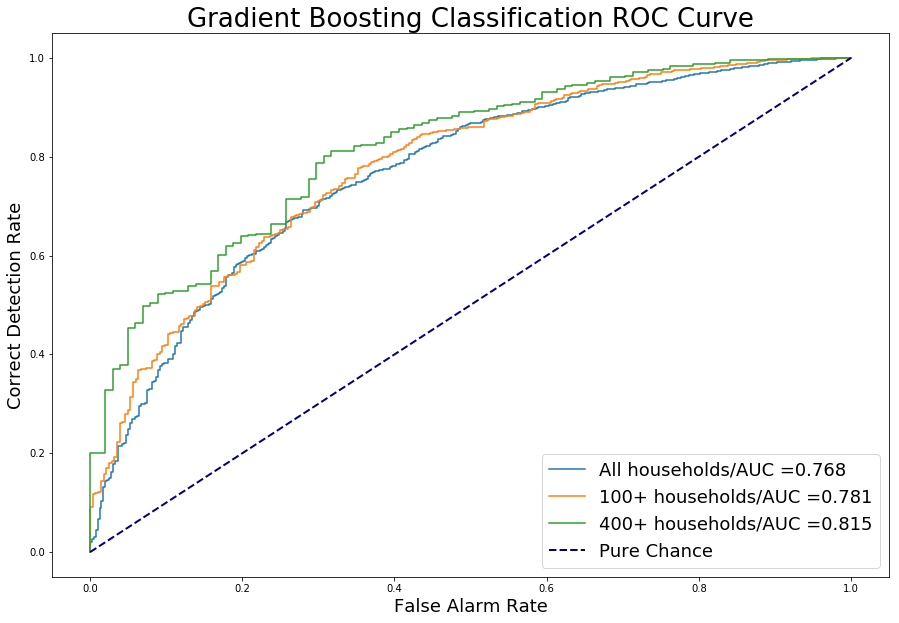

In [12]:
plt.figure(figsize=(15,10))
plot_roc_curve(dfall, labels_all, "All households")
plot_roc_curve(df100, labels_100, "100+ households")
plot_roc_curve(df400, labels_400, "400+ households")
# plot_roc_curve(pca_dfall, labels_all, "PCA All households")
# plot_roc_curve(pca_df100, labels_100, "PCA 100+ households")
# plot_roc_curve(pca_df400, labels_400, "PCA 400+ households")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Pure Chance")
plt.legend(loc=4, fontsize=18)
plt.xlabel('False Alarm Rate', fontsize=18)
plt.ylabel('Correct Detection Rate', fontsize=18)
plt.title('Gradient Boosting Classification ROC Curve', fontsize=26)
plt.show()